The following cell will import WPTherml and set up a base structure that we will evaluate for selective thermal emission for solar thermophotovoltaic (STPV) applications.  For background information on STPV, a good (and open) review article can be found [here](https://cyberleninka.org/article/n/867899).

In [5]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np


# Example input dictionary
test_args = {
    "wavelength_list": [400e-9, 800e-9, 30000],  # 100 wavelengths from 400 to 800 nm
    "material_list": ["Air", "SiO2", "TiO2","Air"],
    "thickness_list": [0, 200e-9, 10e-9,0],
}




TEW is 0.3333333333333333
REW is 0.3333333333333333
RSW is 0.3333333333333333
1.0
 Your spectra have been computed! 😎 
(4,)


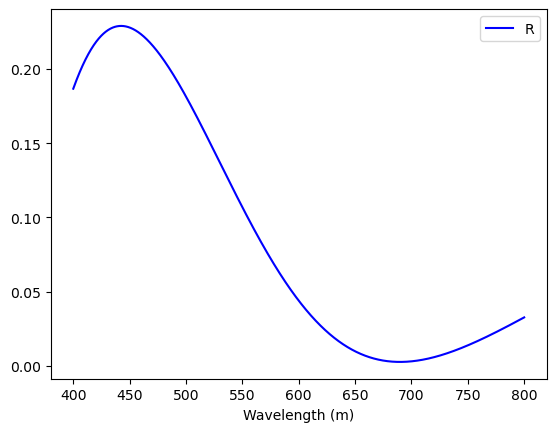

In [6]:
sf = wptherml.SpectrumFactory()
test = sf.spectrum_factory('Tmm', test_args)

plt.plot(test.wavelength_array * 1e9, test.reflectivity_array, 'blue', label=r"R")

print(np.shape(test.thickness_array))

plt.xlabel(r"Wavelength (m)")
plt.legend()
plt.show()

In [ ]:
GOING TO PRINT TM FOR WAVELENGTH 400.0 nm
[[0.3972409 +1.03556999j 0.25953365+0.40324109j]
 [0.25954932-0.40288906j 0.39719967-1.03521661j]]
GOING TO PRINT TM FOR WAVELENGTH 600.0 nm
[[-0.9893825 +0.25898347j -0.01140536+0.21405628j]
 [-0.01140536-0.21405628j -0.9893825 -0.25898347j]]
GOING TO PRINT TM FOR WAVELENGTH 800.0 nm
[[-0.7968421 -0.63149257j -0.06852945-0.17042274j]
 [-0.06852945+0.17042274j -0.7968421 +0.63149257j]]

In [7]:
n_1 = 1.5 + 0j
n_2 = 2.2 + 0.01j

for i in range(1,3):
    if i%2==0: # even
        test._refractive_index_array[:,i] = n_2
    elif i%2==1: # odd
        test._refractive_index_array[:,i] = n_1
        
import time
start = time.time()
test.compute_spectrum()
end = time.time()


In [8]:
print(end-start)

0.4348311424255371


Now we will modify the thickness of the 3 layers between the top-most alloy layer and the bottom-most tungsten layer.  These 3 layers consist of SiO$_2$, TiO$_2$, and SiO$_2$ respectively. We will see that there is an incredible amount of flexibility in terms of the thermal emission spectra and the $\eta$ and $\rho$ figures of merit that can be realized by tuning the thickness of these 3 layers.  We could systematically vary the layer thicknesses in some range of reasonable thicknesses, or we could randomly select thicknesses in such a range.  In the cell below, we will randomly assign the thicknesses of each of the three layers 5000 times for a total of 5000 different instances of the emitter structure.  We will choose a random integer for each layer between 1 and 500 and scale it by 1e-9 so that we are effectly randomly choosing thicknesses between 1e-9 and 500e-9 m for each layer.  For each of these 5000 structures, we will compute and store the STPV spectral efficiency and power density for further analysis. 

In [ ]:

n_layers = 3
N = 5000
thicknesses = np.random.randint(500, size=(N, n_layers))
solutions = np.zeros((N, n_layers+2))

solutions[:,:n_layers] = thicknesses

for i in range(0, N):
    test.thickness_array[2:5] = solutions[i,:3] * 1e-9
    test.compute_stpv()
    solutions[i,3] = test.stpv_spectral_efficiency
    solutions[i,4] = test.stpv_power_density
    

Now we will use the `is_dominated()` function to identify all of the solutions that are dominated by other solutions; the list of dominated solutions is *complementary* to the Pareto optimal solutions.  In particular, the `is_dominate()` function will look at the values of $\rho$ and $\eta$ stored in the `solutions` array and return the indices of all the entries of `solutions` that are dominated by at least one other entry in `solutions`.  Since the Pareto front is comprised only of solutions which are **not** dominated by any other solutions, we can identify the solutions on the Pareto front by deleting all of the solutions that are dominated by at least one other solution.  This deletion can be easily accomplished using `np.delete()` since we have the indices of the solutions we want to delete from the output of `is_dominated()`.  

Note that the values of $\eta$ are stored in the entries of column 4 of the solutions array (`solutions[:,3]`) and the $\rho$ values are stored in the entries of column 5 of the solutions array (`solutions[:,4]`).

In [ ]:
# get the indices of all solutions that are dominated by at least 1 other solution
dominated_indices = is_dominated(solutions[:,3], solutions[:,4])

# collect the Pareto front as the solutions which are *NOT* dominated by any others
pareto_solutions = np.delete(solutions, dominated_indices, axis=0)


We will now look at the values of $\eta$ and $\rho$ for each of the randomly generated structures, and we will also identify the Pareto front of $\eta$ and $\rho$ values.  In these plots, the x-axis values are the $\eta$ values and the y-axis values are the $\rho$ values.  

In [ ]:
plt.plot(solutions[:,3], solutions[:,4], 'ro', label="All Solutions")
plt.plot(pareto_solutions[:,3],  pareto_solutions[:,4], 'bo', label="Pareto Front")
plt.xlabel("STPV Spectral Efficiency")
plt.ylabel("STPV Power Density (W/m^2)")
plt.legend()
plt.show()

Now we will look at the solution on the Pareto front with the highest value of $\eta$ and the solution with the highest value of $\rho$ and plot the spectrum of both of them.

In [ ]:
# get the index of the solution with the largest value of \eta
max_eta_index = np.argmax(pareto_solutions[:,3])
# get the index of the solution with the largest value of \rho
max_rho_index = np.argmax(pareto_solutions[:,4])

# update the multilayer with the thicknesses of the solution that maximizes \eta
test.thickness_array[2:5] = pareto_solutions[max_eta_index,:3] * 1e-9
test.compute_stpv()
max_eta_spectrum = test.thermal_emission_array

# get the \eta and \rho values from this structure 
# and double check they match the results in the pareto_solutions array
max_eta_val = test.stpv_spectral_efficiency
rho_val = test.stpv_power_density

assert np.isclose(max_eta_val, pareto_solutions[max_eta_index, 3])
assert np.isclose(rho_val, pareto_solutions[max_eta_index, 4])

print(" Details of the structure that maximizes the STPV Spectral Efficiency")
print(" Thicknesses of layers 2-4:", pareto_solutions[max_eta_index, 0], 
      pareto_solutions[max_eta_index, 1], 
      pareto_solutions[max_eta_index, 2])

print(" Spectral Efficiency (%):", pareto_solutions[max_eta_index, 3] * 100)
print(" Power Density (W/m^2):", pareto_solutions[max_eta_index, 4])

# update the multilayer with the thicknesses of the solution that maximizes \rho
test.thickness_array[2:5] = pareto_solutions[max_rho_index,:3] * 1e-9
test.compute_stpv()
max_rho_spectrum = test.thermal_emission_array

# get the \eta and \rho values from this structure 
# and double check they match the results in the pareto_slutions array
max_rho_val = test.stpv_power_density
eta_val = test.stpv_spectral_efficiency

assert np.isclose(max_rho_val, pareto_solutions[max_rho_index,4])
assert np.isclose(eta_val, pareto_solutions[max_rho_index, 3])

print("\n Details of the structure that maximizes the STPV Power Density")
print(" Thicknesses of layers 2-4:", pareto_solutions[max_rho_index, 0], 
      pareto_solutions[max_rho_index, 1], 
      pareto_solutions[max_rho_index, 2])

print(" Spectral Efficiency (%):", pareto_solutions[max_rho_index, 3] * 100)
print(" Power Density (W/m^2):", pareto_solutions[max_rho_index, 4])


plt.plot(test.wavelength_array, max_eta_spectrum, 'blue', label=r"Max $\eta$")
plt.plot(test.wavelength_array, max_rho_spectrum, 'red', label=r"Max $\rho$")
plt.plot(test.wavelength_array, test.blackbody_spectrum, 'black', label="Blackbody Spectrum")
plt.ylabel(r"Power density ($W/m^2$)")
plt.xlabel(r"Wavelength (m)")
plt.legend()
plt.show()




In [ ]:
import numpy as np
class MyBounds(object):
      ### note xmax and xmin need to have as many elements as there are thicknesses that are varied
    def __init__(self, xmax=30000.*np.ones(5), xmin=1.0*np.ones(5)):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin



In [ ]:
mybounds = MyBounds()

In [ ]:
print(mybounds.xmax)

In [ ]:
from numpy import arange
from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e
from numpy import pi
from numpy import meshgrid
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
 
# objective function
def objective(x, y):
 return -20.0 * exp(-0.2 * sqrt(0.5 * (x**2 + y**2))) - exp(0.5 * (cos(2 * pi * x) + cos(2 * pi * y))) + e + 20
 
# define range for input
r_min, r_max = -5.0, 5.0
# sample input range uniformly at 0.1 increments
xaxis = arange(r_min, r_max, 0.1)
yaxis = arange(r_min, r_max, 0.1)
# create a mesh from the axis
x, y = meshgrid(xaxis, yaxis)
# compute targets
results = objective(x, y)
# create a surface plot with the jet color scheme
figure = pyplot.figure()
axis = figure.gca(projection='3d')
axis.plot_surface(x, y, results, cmap='jet')
# show the plot
pyplot.show()

In [ ]:
# basin hopping global optimization for the ackley multimodal objective function
from scipy.optimize import basinhopping
from numpy.random import rand
from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e
from numpy import pi
 
# objective function
def objective(v):
 x, y = v
 return -20.0 * exp(-0.2 * sqrt(0.5 * (x**2 + y**2))) - exp(0.5 * (cos(2 * pi * x) + cos(2 * pi * y))) + e + 20
 
# define range for input
r_min, r_max = -5.0, 5.0
# define the starting point as a random sample from the domain
pt = r_min + rand(2) * (r_max - r_min)
# perform the basin hopping search
result = basinhopping(objective, pt, stepsize=0.5, niter=200)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

In [ ]:
_d = np.random.randint(-10, 10)

In [ ]:
print(_d)